# Handwritten numbers generation using GAN

## Topic

In this notebook I will experiement with a simple Generative Adversarial Network or GAN to try to generate images of handwriten digits using the MNIST dataset. The network is composed of two adversarial network: a generator and a discriminator, the discriminator's job is to differentiate between real images and fake images made by the generator, and the generator's job is to try and create new images of the same size as the input from some noise z using transposed convolution layers. After training the network I will generate some images so let's see how good they will be !

## Objectives

- Build two adversarial networks and train them simutaniously
- Generate images of hand-written digits

## Summary

- Importing libraries
- The dataset
- The discriminator
- The generator
- Building the network
- Setting up the losses
- Training the network
- Inference
- Conclusion

### Importing Libraries

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import cv2
from glob import glob
import random

### The dataset

In [2]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor()])

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

In [3]:
batch_size = 64
img_size = 28

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, drop_last=True)

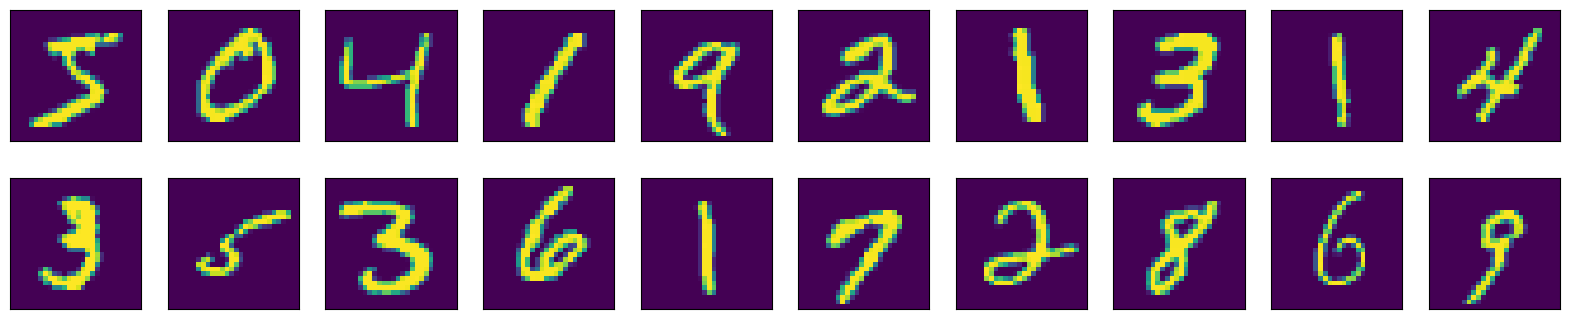

In [4]:
def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

images, _ = next(iter(train_loader))
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    show_img(images[idx])

In [5]:
x,y = next(iter(train_loader))
print(x.min())
print(x.max())

tensor(0.)
tensor(1.)


So the first thing I did was to create transforms that will transform my raw images into normalized tensors who's values range between 0 and 1. then I sat the batch size and images size and displayed some examples to see how the data looks like.

### The Disciminator

In [56]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim*8)
        self.fc2 = nn.Linear(hidden_dim*8, hidden_dim*4)
        self.fc3 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_size)

        
        self.dropout = nn.Dropout(p=0.3)
        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dropout(F.leaky_relu(self.fc1(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc2(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc3(x),0.2))
        x = self.dropout(F.leaky_relu(self.fc4(x),0.2))
        x = self.fc5(x)

        return x
#tests.test_discriminator(Discriminator)

The discriminator is nothing but a simple network of fully connected layers, which accepts an input size of height*width of the image, and outputs logits to whether or not the image fed is real.

### The Generator

In [57]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc5 = nn.Linear(hidden_dim*2, output_size)
    
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.fc1(x),0.2))
        x = self.dropout(F.leaky_relu(self.fc2(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc3(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc4(x), 0.2))
        x = F.tanh(self.fc5(x))
        return x
#tests.test_generator(Generator)

The generator is also a simple network of fully connected layers but it receives a noise data of size 100 (the typical size used) and returns a flattened image that resembles to the training images.

### Building the network

In [58]:
def build_network(d_input, hidden_dim, d_output, g_input, g_output):
    D = Discriminator(d_input, hidden_dim, d_output)
    G = Generator(g_input, hidden_dim, g_output)
    
    
    print(D)
    print()
    print(G)
    
    return D, G

In [59]:
d_input = 28*28
hidden_dim = 32
d_output = 1
g_input = 100
g_output = 28*28
z_size = g_input
D, G = build_network(d_input, hidden_dim, d_output, g_input, g_output)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In the above I simply gathered both the generator and discriminator in one network, sat up the parameters and printed the resulting model.

### Setting up the losses

In [60]:
criterion = nn.BCEWithLogitsLoss()

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    loss = criterion(D_out.squeeze(), labels)
    return loss

So I set up two loss functions, the first is real loss which will output 1 as the label for real images, and a smoothed label 0.9 as label for images created by the generator. The fake loss has a label of 0.

### Training the network

In [61]:
import torch.optim as optim
d_lr = 0.002
g_lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr=d_lr)
g_optimizer = optim.Adam(G.parameters(), lr=g_lr)

In [62]:
def train(D, G, n_epochs, print_every = 400):
    samples = []
    losses = []
    sample_size = 16
    fixed_z = np.random.uniform(-1,1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    for epoch in range(n_epochs):
        for batch_i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images*2 - 1
            #real_images = real_images.float()
            d_optimizer.zero_grad()
            r_output = D(real_images)
            r_loss = real_loss(r_output, True)
            
            with torch.no_grad():
                z = np.random.uniform(-1,1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                fake_images = G(z)
            f_output = D(fake_images)
            f_loss = fake_loss(f_output)
            
            d_loss = r_loss + f_loss
            d_loss.backward()
            d_optimizer.step()
            
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake = G(z)
            fake_output = D(fake)
            g_loss = real_loss(fake_output)
            g_loss.backward()
            g_optimizer.step()
            
            if batch_i % print_every == 0:
                
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
        losses.append((d_loss.item(), g_loss.item()))       
        G.eval()
        with torch.no_grad():
            sample_z = G(fixed_z)
            sample_z = sample_z.detach()
            samples.append(sample_z)
        G.train()
    with open('GAN_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    return losses

In [68]:
n_epochs = 10

losses = train(D, G, n_epochs)

Epoch [    1/   10] | d_loss: 1.1656 | g_loss: 1.1217
Epoch [    1/   10] | d_loss: 1.0856 | g_loss: 2.0307
Epoch [    1/   10] | d_loss: 1.1563 | g_loss: 1.6009
Epoch [    2/   10] | d_loss: 1.1980 | g_loss: 1.6840
Epoch [    2/   10] | d_loss: 1.0017 | g_loss: 1.7637
Epoch [    2/   10] | d_loss: 1.1889 | g_loss: 1.2833
Epoch [    3/   10] | d_loss: 1.1697 | g_loss: 1.2941
Epoch [    3/   10] | d_loss: 1.0610 | g_loss: 1.5791
Epoch [    3/   10] | d_loss: 1.1479 | g_loss: 1.1057
Epoch [    4/   10] | d_loss: 1.0733 | g_loss: 1.2347
Epoch [    4/   10] | d_loss: 1.1869 | g_loss: 1.1515
Epoch [    4/   10] | d_loss: 1.1544 | g_loss: 1.2370
Epoch [    5/   10] | d_loss: 1.3221 | g_loss: 1.2543
Epoch [    5/   10] | d_loss: 1.2719 | g_loss: 1.2886
Epoch [    5/   10] | d_loss: 1.2194 | g_loss: 1.3305
Epoch [    6/   10] | d_loss: 1.2974 | g_loss: 0.8206
Epoch [    6/   10] | d_loss: 1.1390 | g_loss: 1.1977
Epoch [    6/   10] | d_loss: 1.4004 | g_loss: 1.1422
Epoch [    7/   10] | d_loss

So the training happened over 10 epochs, in each epoch I passed a real image into the discriminator and a fake image as well, I calculated the loss by combining both losses and did the backpropagation step to update the discriminator's gradients. Next I created images using the generator and passed them through the discriminator as if they were real, calculated the loss and backpropagated on this loss to update the generator's gradients.

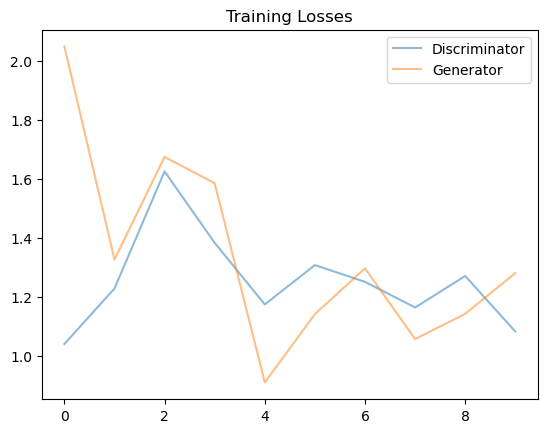

In [69]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

The loss plot shows that the generator's and discriminator's losses alternate between slightly higher and slightly lower which is totaly normal for adversarial networks

### Inference

In [70]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [71]:
with open('GAN_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

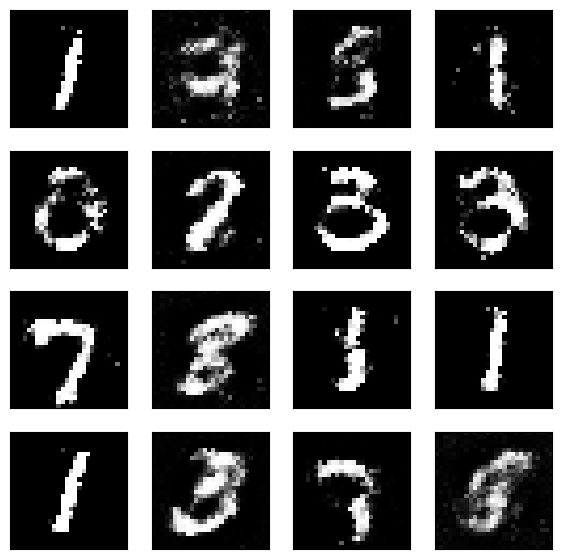

In [72]:
_ = view_samples(-1, samples)

Finally I plotted some examples generated by the network, some of them are clear and can be read easily but other are more blurred and not excatly clear on what the number is

### Conclusion

In this project I had the oppotunity to work with a simple GAN to generate images of handwritten numbers. After normalizing and transforming my images, I put them through a network comprised of two adversarial networks (one that generates images and one that discriminates between real and fake images), the error generated by the network was moderate the final inference result is also moderate (seen as not all the images generated can be easily read). All in all I can say that the performance of my network is average.